In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
mlde_all = pd.read_csv("results/mlde/all_df_comb_onehot.csv")

In [6]:
from SSMuLA.landscape_global import LIB_TYPES

In [7]:
active_lib_list = [
    "DHFR",
    "ParD2",
    "ParD3",
    "GB1",
    "TrpB3D",
    "TrpB3E",
    "TrpB3F",
    "TrpB3G",
    "TrpB3I",
    "TrpB4",
]

In [8]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.125, 0.25, 0.5, 1]

In [52]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_mut_cutoff, zs_list, active_lib_list, ft_frac = 0.125):
    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs_list))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ]

    if "none" not in zs_list:
        lib_dfs = []
        for lib in active_lib_list:
            lib_df = slice_mlde[slice_mlde["lib"] == lib].copy()
            lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                {
                    numb: frac
                    for numb, frac in zip(
                        sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST
                    )
                }
            )
            lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
        slice_mlde = pd.concat(lib_dfs)

    avg_mlde = slice_mlde[["n_sample", "top_maxes", "if_truemaxs", "zs"]].groupby(["n_sample", "zs"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [53]:
def get_mlde_avg_df(mlde_all, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
    ][["n_sample", "top_maxes", "if_truemaxs", "zs"]].groupby(["n_sample", "zs"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
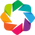

In [11]:
from SSMuLA.zs_analysis import ZS_OPTS
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE

%matplotlib inline

In [12]:
ZS_OPTS

['ed_score', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score']

In [13]:
FTLIB_FRAC_LIST[:-1]

[0.125, 0.25, 0.5]

In [61]:
# for avg cross number of samples
n_top = 96
n_corr = 384

random_avg = get_mlde_avg_df(mlde_all, n_top, "all", ["none"], active_lib_list)
db = get_mlde_avg_df(mlde_all, n_top, "double", ["none"], active_lib_list)
db["zs_"] = "ed_score"

frac_ft_dict = {}

for frac in FTLIB_FRAC_LIST[:-1]:
    avg_mlde = get_mlde_avg_sdf(mlde_all, n_top, "all", ZS_OPTS, active_lib_list, ft_frac = frac)
    frac_ft_dict[frac] = avg_mlde

In [62]:
db

,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std
n_sample,,,,,
24,ed_score,0.690363,0.301229,0.1380,0.345073
48,ed_score,0.771400,0.261207,0.2140,0.410332
96,ed_score,0.855344,0.208093,0.3920,0.488441
192,ed_score,0.922755,0.143043,0.5750,0.494590
288,ed_score,0.937091,0.121463,0.6300,0.483046
384,ed_score,0.940787,0.113541,0.6455,0.478481
480,ed_score,0.943692,0.107340,0.6490,0.477522
576,ed_score,0.946117,0.105097,0.6630,0.472921
960,ed_score,0.947957,0.103761,0.6920,0.461898


In [56]:
frac_ft_dict[0.125].loc[[96, 384]].reset_index()

,n_sample,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std
0,96,Triad_score,0.830559,0.255397,0.405,0.491138
1,96,esm_score,0.885658,0.184504,0.457,0.498397
2,96,esmif_score,0.879860,0.205431,0.583,0.493310
3,96,ev_score,0.894717,0.189174,0.580,0.493805
4,384,Triad_score,0.930191,0.140818,0.603,0.489398
5,384,esm_score,0.950328,0.110125,0.701,0.457934
6,384,esmif_score,0.960360,0.095843,0.787,0.409530
7,384,ev_score,0.966524,0.085904,0.811,0.391607


In [63]:
frac_ft_dfs = []
for frac in FTLIB_FRAC_LIST[:-1]:
    frac_ft_dfs.append(frac_ft_dict[frac].loc[[96, 384]].reset_index().assign(ft_lib_size = frac))
frac_ft_dfs.append(random_avg.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))
frac_ft_dfs.append(db.loc[[96, 384]].reset_index().assign(ft_lib_size = 1))

In [69]:
frac_ft_df = pd.concat(frac_ft_dfs)
frac_ft_df

,n_sample,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
0,96,Triad_score,0.830559,0.255397,0.4050,0.491138,0.125
1,96,esm_score,0.885658,0.184504,0.4570,0.498397,0.125
2,96,esmif_score,0.879860,0.205431,0.5830,0.493310,0.125
3,96,ev_score,0.894717,0.189174,0.5800,0.493805,0.125
4,384,Triad_score,0.930191,0.140818,0.6030,0.489398,0.125
5,384,esm_score,0.950328,0.110125,0.7010,0.457934,0.125
6,384,esmif_score,0.960360,0.095843,0.7870,0.409530,0.125
7,384,ev_score,0.966524,0.085904,0.8110,0.391607,0.125
0,96,Triad_score,0.848580,0.228744,0.3980,0.489730,0.250
1,96,esm_score,0.845927,0.235119,0.4210,0.493967,0.250


In [77]:
slice_df[slice_df["zs_"]=="none"][ms[i]].values[0]

0.8800494348788065

In [81]:
from SSMuLA.zs_analysis import ZS_OPTS_LEGEND

In [83]:
ZS_OPTS_LEGEND

{'none': 'Random',
 'ed_score': 'Edited distance',
 'Triad_score': 'Triad',
 'ev_score': 'EVmutation',
 'esm_score': 'ESM',
 'esmif_score': 'ESM-IF',
 'struc-comb_score': 'Triad + ESM-IF',
 'Triad-ev_score': 'Triad + EVmutation',
 'Triad-esm_score': 'Triad + ESM',
 'msanoif-comb_score': 'EVmutation + ESM',
 'msa-comb_score': 'EVmutation + ESM + ESM-IF',
 'structnmsa-comb_score': 'Triad + EVmutation + ESM + ESM-IF'}

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
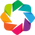

In [86]:
from SSMuLA.vis_summary import ZS_COLOR_MAP_APPENDED, ZS_OPTS_APPENDED

In [87]:
ZS_COLOR_MAP_APPENDED

{'none': '#666666',
 'Triad_score': '#4bacc6',
 'ev_score': '#9bbb59',
 'esm_score': '#8064a2',
 'esmif_score': '#ff8888',
 'struc-comb_score': '#849895',
 'msanoif-comb_score': '#9DAE88',
 'msa-comb_score': '#F1D384',
 'structnmsa-comb_score': '#C7B784',
 'double': '#f79646ff',
 'single': '#f9be00'}

In [95]:
slice_df[slice_df["zs_"]!="none"]

,n_sample,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
4,384,Triad_score,0.930191,0.140818,0.6030,0.489398,0.125
5,384,esm_score,0.950328,0.110125,0.7010,0.457934,0.125
6,384,esmif_score,0.960360,0.095843,0.7870,0.409530,0.125
7,384,ev_score,0.966524,0.085904,0.8110,0.391607,0.125
4,384,Triad_score,0.937725,0.129561,0.6180,0.485998,0.250
5,384,esm_score,0.947847,0.116053,0.6895,0.462814,0.250
6,384,esmif_score,0.951197,0.112689,0.7135,0.452239,0.250
7,384,ev_score,0.953286,0.110952,0.7165,0.450810,0.250
4,384,Triad_score,0.911865,0.174863,0.5550,0.497090,0.500
5,384,esm_score,0.919089,0.167098,0.5865,0.492584,0.500


In [96]:
five_zs = {'none': PRESENTATION_PALETTE_SATURATE["gray"],
 'ed_score': PRESENTATION_PALETTE_SATURATE["orange"],
 'Triad_score': PRESENTATION_PALETTE_SATURATE["blue"],
 'ev_score': PRESENTATION_PALETTE_SATURATE["green"],
 'esm_score': PRESENTATION_PALETTE_SATURATE["purple"],
 'esmif_score': PRESENTATION_PALETTE_SATURATE["yellow"]}

In [102]:
slice_df

,n_sample,zs_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size
4,384,NaN,0.930191,0.140818,0.6030,0.489398,0.125
5,384,NaN,0.950328,0.110125,0.7010,0.457934,0.125
6,384,NaN,0.960360,0.095843,0.7870,0.409530,0.125
7,384,NaN,0.966524,0.085904,0.8110,0.391607,0.125
4,384,NaN,0.937725,0.129561,0.6180,0.485998,0.250
5,384,NaN,0.947847,0.116053,0.6895,0.462814,0.250
6,384,NaN,0.951197,0.112689,0.7135,0.452239,0.250
7,384,NaN,0.953286,0.110952,0.7165,0.450810,0.250
4,384,NaN,0.911865,0.174863,0.5550,0.497090,0.500
5,384,NaN,0.919089,0.167098,0.5865,0.492584,0.500


In [104]:
list(five_zs.keys())

['none', 'ed_score', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score']

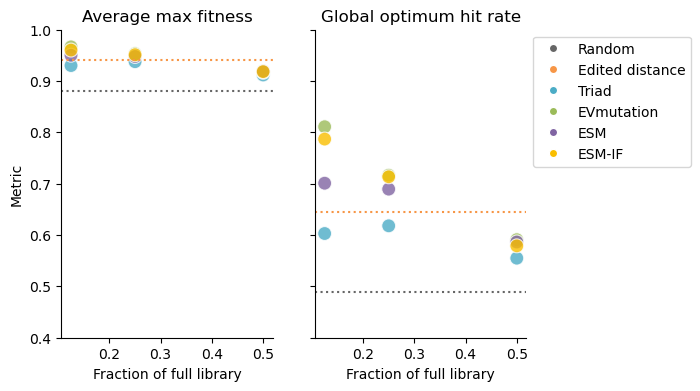

In [111]:
n_sample = 384

# mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]
ms = ["top_maxes_mean", "if_truemaxs_mean"]
titles = ["Average max fitness", "Global optimum hit rate"]

slice_df = frac_ft_df[frac_ft_df["n_sample"] == n_sample].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs_'] = pd.Categorical(slice_df['zs_'], categories=list(five_zs.keys()), ordered=True)

# Sort DataFrame by 'Category'
slice_df = slice_df.sort_values(by='zs_')

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

for i, ax in enumerate(axes):

    ax.axhline(slice_df[slice_df["zs_"]=="none"][ms[i]].values[0], ls="dotted", color=five_zs["none"])
    ax.axhline(slice_df[slice_df["zs_"]=="ed_score"][ms[i]].values[0], ls="dotted", color=five_zs["ed_score"])
    
    ax = sns.scatterplot(
        data=slice_df[~slice_df["zs_"].isin(["none", "ed_score"])],
        x="ft_lib_size",
        y=ms[i],
        hue="zs_",
        s=100,
        alpha=0.8,
        # style="ft_lib_size",
        markers='o',
        ax=ax,
        palette=list(five_zs.values()),
    )
    # ax.set_xscale("log")
    ax.set_xlabel("Fraction of full library")
    ax.set_ylabel("Metric")
    ax.set_title(titles[i])
    ax.set_ylim(0.4, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


axes[0].legend_.remove()  # Remove legend from the first subplot
legend_list = []
for zs, c in five_zs.items():
    legend_list.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, # markersize=10,
    label=ZS_OPTS_APPENDED[zs]))
axes[1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))

    # ax.set_xlim(50, 2000)

Text(0.5, 0.95, 'ftMLDE Varying Focused Libraries Fraction Across 10 Landscapes')

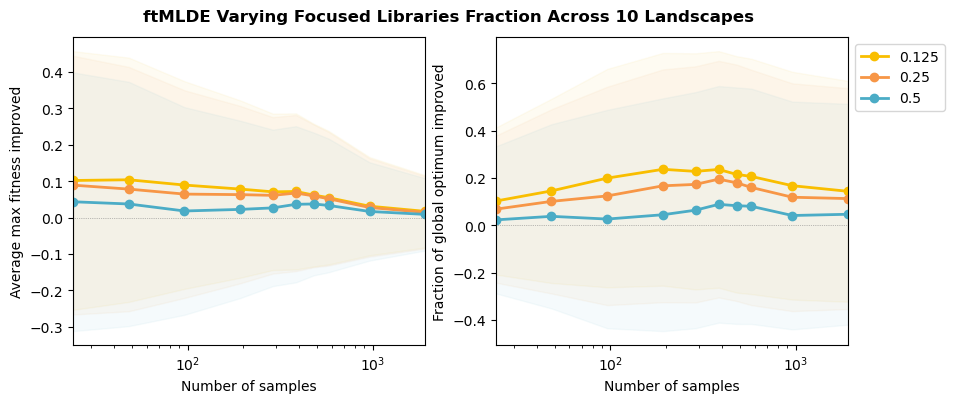

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["yellow", "orange", "blue"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Average max fitness", "Fraction of global optimum"],
):

    for i, (frac_ft, frac_ft_df) in enumerate(frac_ft_dict.items()):
        delta_df = frac_ft_df - random_avg

        ax.plot(
            delta_df.index,
            delta_df[f"{mlde_metric}_mean"],
            label=str(frac_ft),
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            delta_df.index,
            delta_df[f"{mlde_metric}_mean"] - random_avg[f"{mlde_metric}_std"],
            delta_df[f"{mlde_metric}_mean"] + random_avg[f"{mlde_metric}_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )
        
    # # add vline
    # ax.axvline(
    #     n_corr,
    #     color="gray",
    #     linewidth=0.5,
    #     linestyle="dotted"
    # )
    # add hline
    ax.axhline(
        0,
        color="gray",
        linewidth=0.5,
        linestyle="dotted"
    )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    # ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} improved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "ftMLDE Varying Focused Libraries Fraction Across 10 Landscapes", fontsize=12, fontweight="bold", y=0.95
)